[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Plant Segmentation-Background Removal (After Histogram Equalization)-3
Improving background removal algorithm performance on overexposed images.

## Instructions
1. Clone the repository.
2. Download the necessary datasets from Eden Repository:
  1. Black nightsade-22/MAY/2019-v1
3. Unzip dataset files and remove the zip files.
4. Create a folder called 'eden_data'.
5. Move the unzipped datasets into this folder.
6. The resulting directory structure should be:
    * eden_library_notebooks/
       * image_preprocessing/
          * plant_segmentation-background_removal-3.ipynb
       * eden_data/
          * Black nightsade-220519-Weed-zz-V1-20210225102034
7. Install notebook dependencies by running:
    <pre><code>conda env create -f eden_transfer_learning.yml</code></pre>
8. Open the notebook: jupyter notebook
9. Run the code

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will reply you as soon as possible.

## Background

In order to improve the performance of a deep-learning-based system, often a pre-processing step known as background removal is applied. This technique is considered to remove as much noise/background as possible from the image, making the object of study appear as the main part of the picture. Additionally, background removal is not only useful for improving the performance of the deep neural network, but also for reducing <a href="https://en.wikipedia.org/wiki/Overfitting">overfitting</a>. 

In **agriculture**, several works have made use of background removal techniques for achieving a better performance (**Mohanty et al., 2016; McCool et al., 2017; Milioto et al., 2017; Espejo-Garcia et al., 2020**).

Contrast is a parameter that expresses how bright and dark pixels are distributed in the image. Because of complex dynamic lightning conditions or wrong camera configurations, the bright and dark areas of some images could blend together, creating images with a large number of either very dark or very bright pixels that make distinguishing certain relevant features significantly harder. Consequently, this problem can reduce the effectiveness of background removal techniques such as the ones published at [Eden Platform](https://edenlibrary.ai/notebooks).

When background removal algorithms are applied on overexposed images, performance might not be optimal as foreground and background pixels lose their characteristic colors. This results in removing regions of interest (foreground) falsely classified as background.

In this notebook, we are going to combine Histogram Equalization techniques with a **background removal** technique, more specifically the Grabcut algorithm. We are going to make this notebook autonomous and explain the most important steps, but studying the above techniques published in our previous notebooks [Histogram Equalization](https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_preprocessing/plant_classification-histogram_equalization-1.ipynb) and [Background removal](https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_preprocessing/plant_segmentation-background_removal-1.ipynb) is recommended. 

Designed in Rother et al., 2004, this is an algorithm for foreground extraction with minimal user interaction. The Grabcut algorithm works like this:

1. User inputs a rectangle and every pixel outside this rectangle will be taken as sure background. On the other hand,  everything inside rectangle is unknown. The inputs won't change in the process.
2. A Gaussian Mixture Model (GMM) is used to model the foreground and background pixel distribution.
3. The unknown pixels are labelled either probable foreground or probable background depending on its relation with the other previously labelled pixels (step 1) in terms of color statistics.
4. A graph is built from this pixel distribution. Nodes in the graphs are pixels. Additional two nodes are added, Source node and Sink node. Every foreground pixel is connected to Source node and every background pixel is connected to Sink node.
5. The weights of edges connecting pixels are defined by the probability of a pixel being foreground/background. The weights between the pixels are defined by the edge information or pixel similarity. For instance, if there is a large difference in pixel color, the edge between them will get a low weight.
6. Afterwards, a mincut algorithm is used to segment the graph. After the cut, all the pixels connected to Source node become foreground and those connected to Sink node become background.
7. The algorithm will continue until the classification converges.

## The Problem

Below, you can see an overexposed image on the left. On the right we have directly applied the background removal technique mentioned above. 

The overexposure of the image has a deteriorating effect on the performance of the grabcut algorithm. It is obvious that a big part of the object of interest (the plant) has been falsely classified as background and has been removed. Continue reading to see how we can combat this problem by pre-processing the image before grabcut algorithm.<p>
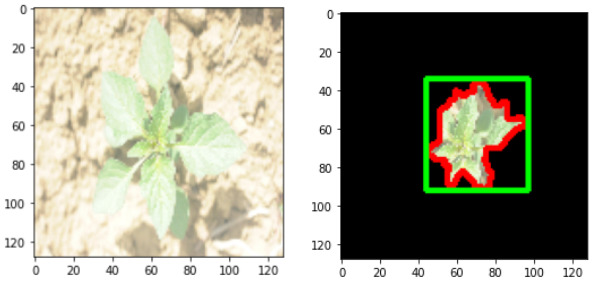


**UPDATES**

*  ***28/04/2021*** Changed the file structure, see instructions for details. ( **IMPORTANT** )
*  ***28/04/2021*** Upgraded read function to become OS agnostic. It now works for both Windows and Linux machines.

## Code Implementation
### Introduction
#### Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from tqdm import tqdm
from glob import glob
from pathlib import Path

%matplotlib inline

#### Auxiliar functions

In [10]:
# Plot multiple numpy arrays at once

def plot_sample(X,title):
    nb_rows = 1 # number of rows
    nb_cols = 5 # number of columns
    # Setting up figure parameters
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(18, 18))
    # Configuring title parameters.
    plt.suptitle(title,verticalalignment='top',horizontalalignment='left', y=0.6 ,fontsize='x-large')
    index=0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[j].xaxis.set_ticklabels([])
            axs[j].yaxis.set_ticklabels([])
            axs[j].imshow(X[index])
            index +=1

In [2]:
# Reads data from the specified paths in path_list
def read_data(path_list, im_size=(128,128)):
    
    X = []
    
    for path in path_list :
        for im_file in tqdm(glob(path + '*/*')):
            try:
                im = cv2.imread(im_file)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, im_size,interpolation=cv2.INTER_LINEAR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                X.append(im)
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")
    
    X = np.array(X)# Convert list to numpy array.
    
    return X

#### Experimental constants

In [3]:
IM_SIZE = (256, 256)
# Datasets' paths we want to work on.
PATH_LIST = ['eden_data/Black nightsade-220519-Weed-zz-V1-20210225102034']

#### Read data

In [4]:
i=0
for path in PATH_LIST:
    #Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path)) 
    i=+1
X = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 123/123 [00:29<00:00,  4.12it/s]


### Applying Histogram Equalization on Multi-channel images

#### Histogram Equalization
To perform Histogram Equalization on a multi-channel image it is necessary to: 
1. Split the image into its respective channels
2. Equalize each channel, and
3. Merge the channels back together.

In [14]:
# Applies histogram equalization on RGB images

def equalize_rgb(im) :
    NUM_CHANNELS = 3
    eqs = [cv2.equalizeHist(im[:,:,i])[:,:,np.newaxis] for i in range(NUM_CHANNELS)]
    equalized_image = cv2.merge((eqs[0], eqs[1], eqs[2]))
    return equalized_image

#### Histogram Equalization with CLAHE
 For more information about CLAHE algorithm check our previous [Eden notebook](https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_preprocessing/plant_classification-histogram_equalization-2.ipynb)

In [15]:
# Applies histogram equalization with the CLAHE technique on RGB images

def clahe_equal(image):
    H, S, V = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2HSV))
    clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(2,2))
    eqV = clahe.apply(V)
    return cv2.cvtColor(cv2.merge([H, S, eqV]), cv2.COLOR_HSV2RGB)

### Background Removal
#### Grabcut algorithm

In [16]:
# Grabcut Implementation

NUM_ITERS = 5 # Number of iterations applied on Grabcut algorithm

# Find contours of an object and draw them around it
def add_contours(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) != 0:
        cv2.drawContours(image, contours, -1, (255, 0, 0), 2)
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0) ,2)

# Apply Grabcut algorithm
def remove_background(image):
    h, w = image.shape[:2]
    mask = init_grabcut_mask(h, w)
    bgm = np.zeros((1, 65), np.float64)
    fgm = np.zeros((1, 65), np.float64)
    # We give the rectangle parameters and let the algorithm run for NUM_ITERS iterations. 
    # The parameter mode should be cv.GC_INIT_WITH_RECT since we are using rectangle. 
    cv2.grabCut(image, mask, None, bgm, fgm, NUM_ITERS, cv2.GC_INIT_WITH_MASK)
    mask_binary = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    
    result = cv2.bitwise_and(image, image, mask = mask_binary)
    add_contours(result, mask_binary) # optional, adds visualizations
    return result

# Set the masks used by grabcut algorithm
def init_grabcut_mask(h, w):
    mask = np.ones((h, w), np.uint8) * cv2.GC_BGD # A trivial background pixel
    mask[h//10:9*h//10, w//10:9*w//10] = cv2.GC_PR_BGD # A possible backgroung pixel
    mask[h//4:3*h//4, w//4:3*w//4] = cv2.GC_PR_FGD # A possible foreground pixel
    mask[2*h//5:3*h//5, 2*w//5:3*w//5] = cv2.GC_FGD # A trivial foreground pixel
    return mask

#### Background Removal on non-processed or equalized images
Histogram equalization is achieved with 2 techniques.

In [39]:
sub_X = X[10:15] # Subset from the nightshade dataset.
filtered_images = []
filtered_images_Eq = []
filtered_images_CLAHE = []

for i in sub_X:
    # Apply background removal and append it to list
    filtered_images.append(remove_background(i))

    # Equalize image, apply background removal and append it to list
    filtered_images_Eq.append(remove_background(equalize_rgb(i)))

    # Equalize image with CLAHE, apply background removal and append it to list
    filtered_images_CLAHE.append(remove_background(clahe_equal(i)))

## Results
As you can see there are cases where applying histogram equalization **improves the accuracy** of the background removal algorithm. In other cases results remain pretty much the same,usually they are already satisfying.

In some rare cases, there might be a slight negative effect on the accuracy of the Grabcut algorithm after HE, but that usually happens when the algorithm doesn't converge well anyway.

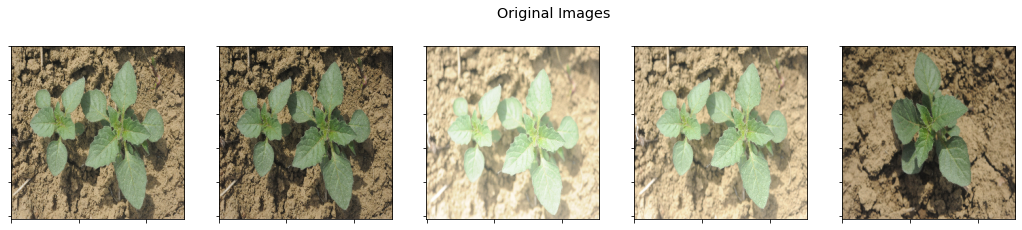

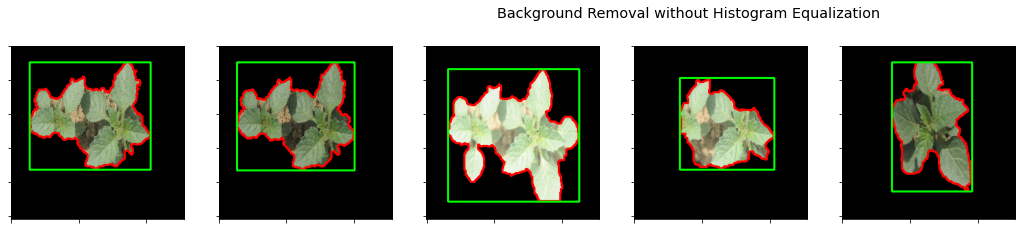

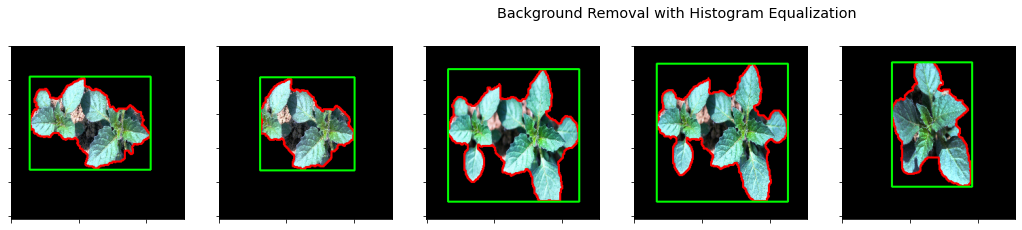

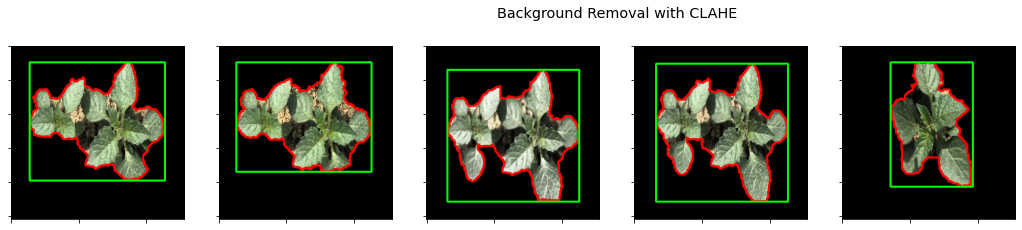

In [40]:
plot_sample(np.array(sub_X ), "Original Images")
plot_sample(np.array(filtered_images), "Background Removal without Histogram Equalization")
plot_sample(np.array(filtered_images_Eq), "Background Removal with Histogram Equalization")
plot_sample(np.array(filtered_images_CLAHE), "Background Removal with CLAHE")

## Possible Extensions
1. Change the number of iterations used by grabcut algorithm (5 in this notebook)
2. Examine histogram equalization on only 1 or 2 channels of multi-channel images.
3. Try the technique with other[ Eden Library datasets](https://edenlibrary.ai/datasets).

## Bibliography

Rother, C., Kolmogorov, V., & Blake, A. (2004). "GrabCut": interactive foreground extraction using iterated graph cuts. ACM SIGGRAPH 2004 Papers.

Mohanty, S.P., Hughes, D.P., Salathé, M., 2016. Using deep learning for image-based plant disease detection. Front. Plant. Sci. 7.

Espejo-García, B., Mylonas, N., Athanasakos, L., Fountas, S., & Vasilakoglou, I. (2020). Towards weeds identification assistance through transfer learning. Comput. Electron. Agric., 171, 105306.

Wikipedia on Histogram Equalization: https://en.wikipedia.org/wiki/Histogram_equalization

Wikipedia on CLAHE:https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#CLAHE

OpenCV on Grabcut: https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html 

OpenCV on Histogram Equalization: https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html

OpenCV on CLAHE: https://docs.opencv.org/3.4/d6/db6/classcv_1_1CLAHE.html

Previous Notebooks: [Histogram Equalization](https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_preprocessing/plant_classification-histogram_equalization-1.ipynb), [Background removal](https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_preprocessing/plant_segmentation-background_removal-1.ipynb)